# Deep dive to deep learning chapter 15: NLP Processing: 
https://d2l.ai/chapter_natural-language-processing-pretraining/index.html


Notes: 
1. self-supervised learning has been extensively used to pretrain text representations, such as by predicting some hidden part of the text using some other part of their surrounding text. --> model learns without expansive labeling efforts

2. word2vec, GloVe, subword embedding. The word vector stays the same without context

3. BERT: adapt representation of the same token to different context. it's a self-supervised model based on Transformer encoder

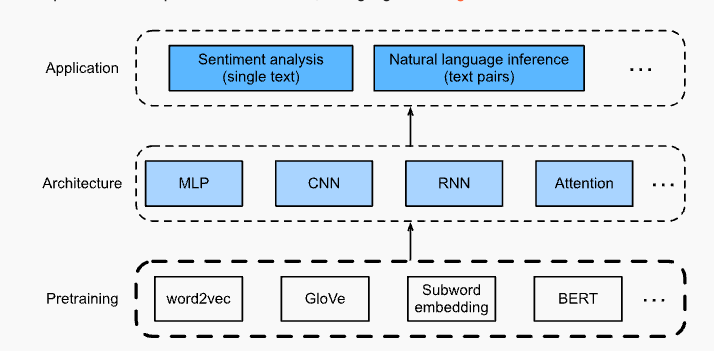


# dataset for pretraining word embedding
https://d2l.ai/chapter_natural-language-processing-pretraining/word-embedding-dataset.html

In [ ]:
!pip install setuptools==66
!pip install matplotlib_inline
!pip install d2l==1.0.0b

In [ ]:
import collections
import math
import os
import random
import torch
from d2l import torch as d2l
from torch import nn


In [ ]:
d2l.DATA_HUB['ptb'] = (d2l.DATA_URL + 'ptb.zip',
                       '319d85e578af0cdc590547f26231e4e31cdf1e42')

def read_ptb():
    """Load the PTB dataset into a list of text lines."""
    data_dir = d2l.download_extract('ptb')
    # Read the training set
    with open(os.path.join(data_dir, 'ptb.train.txt')) as f:
        raw_text = f.read()
    return [line.split() for line in raw_text.split('\n')]

sentences = read_ptb()
print(f'# sentences: {len(sentences)}')
for i in range(10):
  print('sample = ', ' '.join(sentences[i]))

vocab = d2l.Vocab(sentences, min_freq = 10)

print()
print(f"vocab size {len(vocab)}")
print('vocab sample')
print(f'apple = {vocab["apple"]}')


# sentences: 42069
sample =  aer banknote berlitz calloway centrust cluett fromstein gitano guterman hydro-quebec ipo kia memotec mlx nahb punts rake regatta rubens sim snack-food ssangyong swapo wachter
sample =  pierre <unk> N years old will join the board as a nonexecutive director nov. N
sample =  mr. <unk> is chairman of <unk> n.v. the dutch publishing group
sample =  rudolph <unk> N years old and former chairman of consolidated gold fields plc was named a nonexecutive director of this british industrial conglomerate
sample =  a form of asbestos once used to make kent cigarette filters has caused a high percentage of cancer deaths among a group of workers exposed to it more than N years ago researchers reported
sample =  the asbestos fiber <unk> is unusually <unk> once it enters the <unk> with even brief exposures to it causing symptoms that show up decades later researchers said
sample =  <unk> inc. the unit of new york-based <unk> corp. that makes kent cigarettes stopped using <

# Subsampling
https://d2l.ai/chapter_natural-language-processing-pretraining/word-embedding-dataset.html#subsampling

Text data typically have high-frequency words such as “the”, “a”, and “in”: they may even occur billions of times in very large corpora. However, these words often co-occur with many different words in context windows, providing little useful signals. For instance, consider the word “chip” in a context window: intuitively its co-occurrence with a low-frequency word “intel” is more useful in training than the co-occurrence with a high-frequency word “a”

# of "the": before=50770, after=2052
# of "after": before=1137, after=301
# of "contrast": before=51, after=51


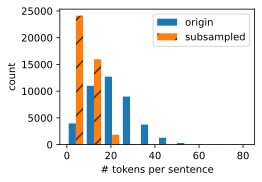

In [ ]:
def subsample(sentences, vocab):
    """Subsample high-frequency words."""
    # Exclude unknown tokens ('<unk>')
    sentences = [[token for token in line if vocab[token] != vocab.unk] for line in sentences]
    counter = collections.Counter([
        token for line in sentences for token in line])
    num_tokens = sum(counter.values())

    # Return True if `token` is kept during subsampling
    def keep(token):
        return(random.uniform(0, 1) <
               math.sqrt(1e-4 / counter[token] * num_tokens))

    return ([[token for token in line if keep(token)] for line in sentences],
            counter)


subsampled, counter = subsample(sentences, vocab)

#plot histogram
d2l.show_list_len_pair_hist(['origin', 'subsampled'], '# tokens per sentence','count', sentences, subsampled);

# a high-frequency word sample before and after subsampling
def compare_counts(token):
    return (f'# of "{token}": '
            f'before={sum([l.count(token) for l in sentences])}, '
            f'after={sum([l.count(token) for l in subsampled])}')

#very high frequency
print(compare_counts('the'))
#quite high frequency
print(compare_counts('after'))
#low frequecy 
print(compare_counts('contrast'))


# Extracting center words and context words

In [ ]:
# uniformly samples and integer between 1 and max_window_size as context window size
# basically pick the words around the center words 
def get_centers_and_contexts(corpus, max_window_size):
  centers, contexts = [], []

  for line in corpus:
    # each sentence must have at least 2 words
    if len(line) < 2: continue

    centers += line
    for i in range(len(line)):
      window_size = random.randint(1, max_window_size)

      #indicies range = [i - window_size, i + 1 + window_size]
      # max(0, ...) and min(len(line),...) simply prevents out of bound 
      indicies = list(range(max(0, i - window_size), min(len(line), i + 1 + window_size)))
      indicies.remove(i)
      contexts.append([line[idx] for idx in indicies])
    
  return centers, contexts

#test run
sample_ds = [list(range(7)), list(range(7,10))]
print('dataset ', sample_ds)

for center, context in zip(*get_centers_and_contexts(sample_ds, 2)):
  print('center =', center,' has context ', context)

dataset  [[0, 1, 2, 3, 4, 5, 6], [7, 8, 9]]
center = 0  has context  [1, 2]
center = 1  has context  [0, 2, 3]
center = 2  has context  [1, 3]
center = 3  has context  [2, 4]
center = 4  has context  [3, 5]
center = 5  has context  [4, 6]
center = 6  has context  [5]
center = 7  has context  [8]
center = 8  has context  [7, 9]
center = 9  has context  [8]


In [ ]:
corpus = [vocab[line] for line in subsampled]
print('corpus len = ', len(corpus))
all_centers, all_contexts = get_centers_and_contexts(corpus, 5)

print(f'# of centers, contexts pair = {sum([len(contexts) for contexts in all_contexts])}')

corpus len =  42069
# of centers, contexts pair = 1501557


# Negative Sampling
used for approximate training. Sample noise words using a predefined distribution

In [ ]:
class RandomGenerator:
    """Randomly draw among {1, ..., n} according to n sampling weights."""
    def __init__(self, sampling_weights):
        # Exclude
        self.population = list(range(1, len(sampling_weights) + 1))
        self.sampling_weights = sampling_weights
        self.candidates = []
        self.i = 0

    def draw(self):
        if self.i == len(self.candidates):
            # Cache `k` random sampling results
            self.candidates = random.choices(
                self.population, self.sampling_weights, k=10000)
            self.i = 0
        self.i += 1
        return self.candidates[self.i - 1]

        
print('test run RandomGenerator')
gen = RandomGenerator([2,3,4])
sample = [gen.draw() for _ in range(100)]
sample_counter = collections.Counter(sample)
print(sample_counter)

# according to word2vec paper, P(w) of noise word is set to 
# its relative frequency in dictionary raise to power of 0.75
# Sample K noise words
def get_negatives(all_contexts, vocab, counter, K):
    """Return noise words in negative sampling."""
    # Sampling weights for words with indices 1, 2, ... (index 0 is the
    # excluded unknown token) in the vocabulary
    sampling_weights = [counter[vocab.to_tokens(i)]**0.75 for i in range(1, len(vocab))]
    all_negatives, generator = [], RandomGenerator(sampling_weights)
    for contexts in all_contexts:
        negatives = []
        while len(negatives) < len(contexts) * K:
            neg = generator.draw()
            # Noise words cannot be context words
            if neg not in contexts:
                negatives.append(neg)
        all_negatives.append(negatives)
    return all_negatives

all_negatives = get_negatives(all_contexts, vocab, counter, 5)

test run RandomGenerator
Counter({3: 42, 2: 35, 1: 23})


In [ ]:
print('# of negatives = ', len(all_negatives))
print(all_negatives[0])

# of negatives =  342895
[5302, 2457, 857, 4958, 6673, 2770, 6280, 4416, 4107, 6281]


In [ ]:
def batchify(data):
  # return minibatch of exmaples for skip-gram with negative sampling
  max_len = max(len(c) + len(n) for _, c, n in data)
  # concat context words and noise words = contexts_negative 
  # masks exclude <pad> in loss function, a 0 is correspoding to the <pad>, else 1
  # label seperate context words from noise words in context_negatives. 1 = context words, else 0
  centers, contexts_negatives, masks, labels = [], [], [], []

  for center, context, negative in data:
    current_len = len(context) + len(negative)
    centers += [center]
    contexts_negatives += [context + negative + [0] * (max_len - current_len)]
    masks += [[1] * current_len + [0] * (max_len - current_len)]
    labels += [[1] * len(context) + [0] * (max_len - len(context))]
  
  return (torch.tensor(centers).reshape(-1, 1), 
          torch.tensor(contexts_negatives), 
          torch.tensor(masks), 
          torch.tensor(labels))

#Test run
#center, context, negative
x_1 = (1,[2,2], [3,3,3,3])
x_2 = (1,[2,2,2], [3,3])
batch = batchify((x_1, x_2))

names = ['centers', 'contexts_negatives', 'masks', 'labels']
for name, data in zip(names, batch):
  print(name, ' = ', data)



centers  =  tensor([[1],
        [1]])
contexts_negatives  =  tensor([[2, 2, 3, 3, 3, 3],
        [2, 2, 2, 3, 3, 0]])
masks  =  tensor([[1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0]])
labels  =  tensor([[1, 1, 0, 0, 0, 0],
        [1, 1, 1, 0, 0, 0]])


In [ ]:
#Put it all together
def load_data_ptb(batch_size, max_window, num_noise_words):
  num_workers = d2l.get_dataloader_workers()
  sentences = read_ptb()
  vocab = d2l.Vocab(sentences, min_freq = 10)
  subsampled, counter = subsample(sentences, vocab)

  corpus = [vocab[line] for line in sentences]

  all_centers, all_contexts = get_centers_and_contexts(corpus, max_window)
  all_negatives = get_negatives(all_contexts, vocab, counter, num_noise_words)

  names = ['centers', 'contexts_negatives', 'masks', 'labels']

  class PTBDataset(torch.utils.data.Dataset):
    def __init__(self, centers, contexts, negatives):
      assert len(centers) == len(contexts) == len(negatives)

      self.centers = centers
      self.contexts = contexts
      self.negatives = negatives
    
    def __getitem__(self, index):
      return (self.centers[index], self.contexts[index], self.negatives[index])
    
    def __len__(self):
      return len(self.centers)
  
  dataset = PTBDataset(all_centers, all_contexts, all_negatives)
  data_iter = torch.utils.data.DataLoader(dataset, batch_size, shuffle= True, collate_fn=batchify, num_workers = num_workers)

  return data_iter, vocab

#Test run
# data_iter, vocab = load_data_ptb(512, 5,5)

# for batch in data_iter:
#   for name, data in zip(names, batch):
#     print(name, 'shape:',data.shape)
#   break

centers shape: torch.Size([512, 1])
contexts_negatives shape: torch.Size([512, 60])
masks shape: torch.Size([512, 60])
labels shape: torch.Size([512, 60])


# Pretraining word2vec

In [ ]:
batch_size, max_window_size, num_noise_words = 512, 5,5
data_iter, vocab = load_data_ptb(batch_size, max_window_size, num_noise_words)
#sample
for batch in data_iter:
  for name, data in zip(names, batch):
    print(name, 'shape:',data.shape)
  break


centers shape: torch.Size([512, 1])
contexts_negatives shape: torch.Size([512, 60])
masks shape: torch.Size([512, 60])
labels shape: torch.Size([512, 60])


In [ ]:
def skip_gram(center, contexts_and_negatives, embed_v, embed_u, debug = False):
  #center shape (batch, 1)
  #context and negative shape (batch, max_len)

  #center word vector
  v = embed_v(center)
  #concat context and negatives vector 
  u = embed_u(contexts_and_negatives)

  # TODO: I don't know why they permute this with permute(0,2,1)
  # bmm (2,1,4) and (2,4,4) --> (2,1,4)
  pred = torch.bmm(v,u.permute(0,2,1))
  if debug:
    print('v shape =',v.shape)
    print('u shape =',u.shape)
    tmp = u.permute(0,2,1)
    print('u permute shape =',tmp.shape)
    print('output shape = ', pred.shape)
  return pred

embed = nn.Embedding(num_embeddings = 20, embedding_dim = 4)
center = torch.ones((2,1), dtype=torch.long)
contexts_and_negatives = torch.ones((2,4), dtype=torch.long)
output = skip_gram( center, contexts_and_negatives, embed, embed, True)


v shape = torch.Size([2, 1, 4])
u shape = torch.Size([2, 4, 4])
u permute shape = torch.Size([2, 4, 4])
output shape =  torch.Size([2, 1, 4])


In [ ]:
#Define loss function
class SigmoidBSELoss(nn.Module):
  def __init__(self):
    super().__init__()
  
  def forward(self, inputs, target, mask = None):
    out = nn.functional.binary_cross_entropy_with_logits(inputs, target, weight = mask, reduction = 'none')
    return out.mean(dim = 1)
  
#Test run
loss = SigmoidBSELoss()

pred = torch.tensor([[1.1, -2.2, 3.3, -4.4] ]* 2)
print(pred.shape)
label = torch.tensor([[1.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0]])
#used to suppress input in loss function
mask = torch.tensor([[1,1,1,1], [1,1,0,0]])
output = loss(pred, label, mask) 
# TODO: why do they do this?
output = output * mask.shape[1] / mask.sum(axis = 1)
print(output.shape)

torch.Size([2, 4])
tensor([0.9352, 0.9231])
torch.Size([2])
tensor([4, 2])
torch.Size([2])


loss=0.3550226183270264


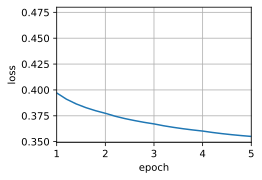

In [ ]:
#init model params

embed_size = 100

net = nn.Sequential(
    #for center
    nn.Embedding(num_embeddings = len(vocab), embedding_dim = embed_size),
    #for context
    nn.Embedding(num_embeddings = len(vocab), embedding_dim = embed_size),
    )

#Training loop
def train(net, data_iter, lr, num_epochs, device = d2l.try_gpu()):
  def init_weights(module):
    if type(module) == nn.Embedding:
      nn.init.xavier_uniform_(module.weight)
  
  net.apply(init_weights)
  net = net.to(device)

  optimizer = torch.optim.Adam(net.parameters(), lr = lr)
  animator = d2l.Animator(xlabel = 'epoch', ylabel = 'loss', xlim=[1, num_epochs])

  metric = d2l.Accumulator(2)

  for epoch in range(num_epochs):
    timer, num_batches = d2l.Timer(), len(data_iter)

    for i, batch in enumerate(data_iter):
      optimizer.zero_grad()
      center, context_negative, mask, label = [data.to(device) for data in batch]

      pred = skip_gram(center, context_negative, net[0], net[1])

      l = (loss(pred.reshape(label.shape).float(), label.float(), mask) 
              / mask.sum(axis = 1) * mask.shape[1])
      l.sum().backward()
      optimizer.step()
      metric.add(l.sum(), l.numel())
      if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1: 
        animator.add(epoch + (i + 1) / num_batches, (metric[0] / metric[1], ))
      
      print(f'loss {metric[0] / metric[1]:.3f}, 'f'{metric[1] / timer.stop():.1f} tokens/sec on {str(device)}')

lr, num_epochs = 0.002, 5

train(net, data_iter, lr, num_epochs)


In [ ]:
#get top k similiar words from trained embedding layer 
def get_similar_tokens(query_token, k, embed):
    W = embed.weight.data
    x = W[vocab[query_token]]
    # Compute the cosine similarity. Add 1e-9 for numerical stability
    cos = torch.mv(W, x) / torch.sqrt(torch.sum(W * W, dim=1) *
                                      torch.sum(x * x) + 1e-9)
    topk = torch.topk(cos, k=k+1)[1].cpu().numpy().astype('int32')
    for i in topk[1:]:  # Remove the input words
        print(f'cosine sim={float(cos[i]):.3f}: {vocab.to_tokens(i)}') 

words = ['chip', 'dog', 'years', 'wife', 'baby']
for w in words:
  print('word=',w)
  get_similar_tokens(w, 10, net[0])
  print()


word= chip
cosine sim=0.566: wine
cosine sim=0.538: marking
cosine sim=0.534: painting
cosine sim=0.524: apple
cosine sim=0.514: models
cosine sim=0.512: intel
cosine sim=0.510: apparel
cosine sim=0.509: machine
cosine sim=0.502: mainframe
cosine sim=0.498: category

word= dog
cosine sim=0.635: tale
cosine sim=0.634: village
cosine sim=0.606: man
cosine sim=0.605: headline
cosine sim=0.598: charity
cosine sim=0.594: youth
cosine sim=0.591: story
cosine sim=0.590: piece
cosine sim=0.589: hole
cosine sim=0.588: shoulder

word= years
cosine sim=0.732: weeks
cosine sim=0.707: seasons
cosine sim=0.658: months
cosine sim=0.617: decades
cosine sim=0.614: quarters
cosine sim=0.604: inches
cosine sim=0.591: days
cosine sim=0.587: minutes
cosine sim=0.547: decade
cosine sim=0.529: persons

word= wife
cosine sim=0.737: brother
cosine sim=0.714: sutton
cosine sim=0.704: husband
cosine sim=0.693: boss
cosine sim=0.680: peladeau
cosine sim=0.674: morishita
cosine sim=0.664: recalls
cosine sim=0.660:

# Chapt 15.5 Word Embdding with Global Vectors (GloVe)
https://d2l.ai/chapter_natural-language-processing-pretraining/glove.html

# Chapt 15.6 Subword Embedding
https://d2l.ai/chapter_natural-language-processing-pretraining/subword-embedding.html

thanks to shared parameters from subwords among words with similar structures, rare words and even out-of-vocabulary words may obtain better vector representations in fastText.

YT tutorial: https://www.youtube.com/watch?v=tOMjTCO0htA

In [ ]:
import collections 
import string


In [ ]:
symbols = []
for letter in string.ascii_lowercase:
  symbols.append(letter)

symbols += ['_', '[UNK]']
print(symbols)


['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '_', '[UNK]']


In [ ]:
raw_token_freqs = {'fast': 4, 'faster_': 3, 'tall_': 5, 'taller_': 4}

token_freqs = {}

for token, freq in raw_token_freqs.items():
  token_freqs[' '.join(list(token))] = freq

print(token_freqs)


{'f a s t': 4, 'f a s t e r _': 3, 't a l l _': 5, 't a l l e r _': 4}


In [ ]:
def get_max_freq_pair(token_freqs):
  pairs = collections.defaultdict(int)

  for token, freq in token_freqs.items():
    symbols = token.split()
    for i in range(len(symbols) - 1):
      pairs[symbols[i], symbols[i + 1]] += freq
  return max(pairs, key = pairs.get)    

max_freq_pair = get_max_freq_pair(token_freqs)
print('symbols ', symbols)
print('token freqs ', token_freqs)
print('max freq pair ', max_freq_pair)

# merge the most frequent pair of consecutive symbols to produce new symbols
def merge_symbols(max_freq_pair, token_freqs, symbols):
  symbols.append(' '.join(max_freq_pair))
  new_token_freqs = dict()
  for token, freq in token_freqs.items():
    # print('token = ', token)
    new_token = token.replace(' '.join(max_freq_pair), ''.join(max_freq_pair))
    # print('new token = ', new_token)
    new_token_freqs[new_token] = freq
  
  return new_token_freqs

num_merges = 10
for i in range(num_merges):
  max_freq_pair = get_max_freq_pair(token_freqs)
  token_freqs = merge_symbols(max_freq_pair, token_freqs, symbols)
  print(f'merge #{i + 1}:', max_freq_pair)



symbols  ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '_', '[UNK]', 't a', 't a', 't a', 't a', 't a', 't a', 'ta l', 'tal l', 'f a', 'fa s', 'fas t', 'e r', 'er _', 'tall _', 'tall er_', 'fast er_', 't a', 'ta l', 'tal l', 'f a', 'fa s', 'fas t', 'e r', 'er _', 'tall _', 'tall er_', 'fast er_']
token freqs  {'f a s t': 4, 'f a s t e r _': 3, 't a l l _': 5, 't a l l e r _': 4}
max freq pair  ('t', 'a')
merge #1: ('t', 'a')
merge #2: ('ta', 'l')
merge #3: ('tal', 'l')
merge #4: ('f', 'a')
merge #5: ('fa', 's')
merge #6: ('fas', 't')
merge #7: ('e', 'r')
merge #8: ('er', '_')
merge #9: ('tall', '_')
merge #10: ('tall', 'er_')
['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '_', '[UNK]', 't a', 't a', 't a', 't a', 't a', 't a', 'ta l', 'tal l', 'f a', 'fa s', 'fas t', 'e r', 'er _', 'tall _', 'tall er_', 'fast er_', 't a

# Chapt 15.7 Word Similarity and Analogy

In [ ]:
import os
import torch
from torch import nn
from d2l import torch as d2l

/usr/local/lib/python3.9/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [ ]:
#Download Glove
d2l.DATA_HUB['glove.6b.50d'] = (d2l.DATA_URL + 'glove.6B.50d.zip','0b8703943ccdb6eb788e6f091b8946e82231bc4d')

In [ ]:
class TokenEmbedding:
  def __init__(self, embedding_name):
    self.idx_to_token, self.idx_to_vec = self._load_embedding(embedding_name)
    self.unknown_idx = 0
    #map token back to index
    self.token_to_idx = {token: idx for idx, token in enumerate(self.idx_to_token)} 

  def _load_embedding(self, embedding_name):
    idx_to_token, idx_to_vec = ['<unk>'], []
    data_dir = d2l.download_extract(embedding_name)

    with open(os.path.join(data_dir, 'vec.txt'), 'r') as f:
      for line in f:
        elements = line.rstrip().split(' ')
        token, elements = elements[0], [float(e) for e in elements[1:]]
        if len(elements) > 1:
          idx_to_token.append(token)
          idx_to_vec.append(elements)

      idx_to_vec = [[0] * len(idx_to_vec[0])] + idx_to_vec

      return idx_to_token, torch.tensor(idx_to_vec)

  def __getitem__(self, tokens):
    indices = [self.token_to_idx.get(token, self.unknown_idx) for token in tokens]
    vecs = self.idx_to_vec[torch.tensor(indices)]
    return vecs
  
  def __len__(self):
    return len(self.idx_to_token)

glove = TokenEmbedding('glove.6b.50d')


torch.Size([400001, 50])


In [ ]:
vector = glove.idx_to_vec
tokens =  glove.token_to_idx

print('vector shape ', vector.shape)
words = ['apple', 'juice', 'cat', 'dog']

for w in words:
  idx = tokens[w]
  print(f'word={w}, idx = {idx}, vector = {vector[idx]}')

vector shape  torch.Size([400001, 50])
word=apple, idx = 3293, vector = tensor([ 0.5204, -0.8314,  0.4996,  1.2893,  0.1151,  0.0575, -1.3753, -0.9731,
         0.1835,  0.4767, -0.1511,  0.3553,  0.2591, -0.7786,  0.5218,  0.4769,
        -1.4251,  0.8580,  0.5982, -1.0903,  0.3357, -0.6089,  0.4174,  0.2157,
        -0.0742, -0.5822, -0.4502,  0.1725,  0.1645, -0.3841,  2.3283, -0.6668,
        -0.5818,  0.7439,  0.0950, -0.4787, -0.8459,  0.3870,  0.2369, -1.5523,
         0.6480, -0.1652, -1.4719, -0.1622,  0.7986,  0.9739,  0.4003, -0.2191,
        -0.3094,  0.2658])
word=juice, idx = 6989, vector = tensor([-0.0546, -0.7357, -0.7096,  0.6133,  0.6833,  0.3693, -0.0159, -0.0154,
         0.3847,  1.3228, -0.0331,  0.3743,  1.1427, -0.8178,  0.1197, -0.2817,
        -0.5607,  0.9737,  0.0390, -1.6358,  0.6514, -0.4551,  2.1494,  0.2610,
        -0.9923,  0.0567,  0.5224,  1.3410,  1.3510, -0.1936,  1.9524,  0.1217,
        -0.8731,  1.0831,  0.3580, -0.0635, -1.2023,  0.2801,  1.517

In [ ]:
# K nearest neighbors based on cosine similarity
def knn(W, x, k):
    # Add 1e-9 for numerical stability
    cos = torch.mv(W, x.reshape(-1,)) / (
        torch.sqrt(torch.sum(W * W, axis=1) + 1e-9) *
        torch.sqrt((x * x).sum()))
    _, topk = torch.topk(cos, k=k)
    return topk, [cos[int(i)] for i in topk]
  
def get_similar_tokens(query_token, k, embed):
    topk, cos = knn(embed.idx_to_vec, embed[[query_token]], k + 1)
    for i, c in zip(topk[1:], cos[1:]):  # Exclude the input word
        print(f'cosine sim={float(c):.3f}: {embed.idx_to_token[int(i)]}')

get_similar_tokens('chip', 10, glove)

cosine sim=0.856: chips
cosine sim=0.749: intel
cosine sim=0.749: electronics
cosine sim=0.731: semiconductor
cosine sim=0.716: maker
cosine sim=0.708: computer
cosine sim=0.707: microprocessor
cosine sim=0.703: makers
cosine sim=0.701: micro
cosine sim=0.691: manufacturing


# Word Analogy

a:b :: c:d

find d given a,b,c

man:woman :: son:daughter




In [ ]:
def get_analogy(token_a, token_b, token_c, embed):
    vecs = embed[[token_a, token_b, token_c]]
    x = vecs[1] - vecs[0] + vecs[2]
    topk, cos = knn(embed.idx_to_vec, x, 1)
    return embed.idx_to_token[int(topk[0])]  # Remove unknown words

print(get_analogy('japan', 'tokyo', 'china', glove))

beijing


# 15.8 BERT
https://d2l.ai/chapter_natural-language-processing-pretraining/bert.html


/usr/local/lib/python3.9/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


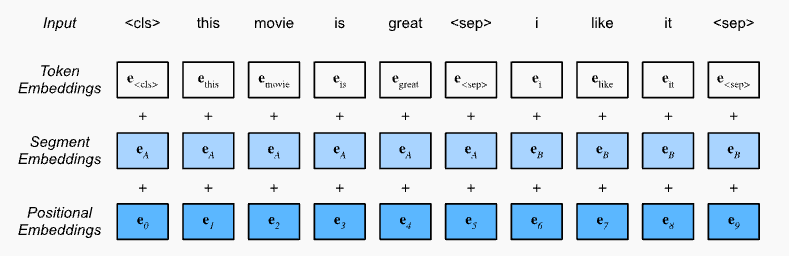

In [ ]:
def get_tokens_and_segments(tokens_a, tokens_b = None):
  tokens = ['<cls>'] + tokens_a + ['<sep>']
  segments = [0] * (len(tokens_a) + 2)
  if tokens_b is not None:
    tokens += tokens_b + ['<sep>']
    segments += [1] * (len(tokens_b) + 1)
  return tokens, segments

In [ ]:
class BERTEncoder(nn.Module):
  def __init__(self, vocab_size, num_hiddens, ffn_num_hiddens, 
               num_heads, num_blocks, dropout, max_len = 1000, **kwargs):
    super(BERTEncoder, self).__init__(**kwargs)
    self.token_embedding = nn.Embedding(vocab_size, num_hiddens)
    self.segment_embedding = nn.Embedding(2, num_hiddens)
    self.blocks = nn.Sequential()

    for i in range(num_blocks):
      self.blocks.add_module(f'{i}', d2l.TransformerEncoderBlock(num_hiddens, ffn_num_hiddens, num_heads, dropout, True))
    
    self.pos_embedding = nn.Parameter(torch.randn(1, max_len, num_hiddens))

  def forward(self, tokens, segments, valid_lens, debug = False):
    #Shape of X remains unchange
    X = self.token_embedding(tokens) + self.segment_embedding(segments)
    if debug:
      print('X shape = ', X.shape)
    X = X + self.pos_embedding[:,:X.shape[1],:]
    if debug:
      print('position embedding = ', self.pos_embedding.shape)

    for block in self.blocks:
      X = block(X, valid_lens)
    
    return X

#Test run
vocab_size, num_hiddens, ffn_num_hiddens, num_heads = 10000, 768, 1024, 4
ffn_num_input, num_blocks, dropout = 768,2, 0.2
encoder = BERTEncoder(vocab_size, num_hiddens, ffn_num_hiddens, num_heads, num_blocks, dropout)

#Just test sample, not a real data
tokens = torch.randint(0, vocab_size, (2,8))
segments = torch.tensor([[0,0,0,0,1,1,1,1], [0,0,0,1,1,1,1,1]])
encoded_X = encoder(tokens, segments, None, True)
#X shape is defined as (2,8), add # hiddens to 3 dim
#X shape = (2,8,768)
print('X shape = ', encoded_X.shape)

# tokens = torch.randint()
# mlm_Y = torch.tensor([7,8,9], [10,20,30])
# loss = nn.CrossEntropyLoss(reduction = 'none')
# mlm_l = loss(mlm_Y_hat.reshape((-1, vocab_size)), mlm_Y.reshape(-1))



/usr/local/lib/python3.9/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


X shape =  torch.Size([2, 8, 768])
position embedding =  torch.Size([1, 1000, 768])
X shape =  torch.Size([2, 8, 768])


In [ ]:
#Mask Language Model

#15% of token will be selected at random for prediction
# replace that token with <mask>
# <mask> willl never be used in fine-tuning  
# 
# if a token is masked for pred, it will be replaced with:
# 1. <mask> token for 80% (the movie is great --> the movie is <mask>)
# 2. random token for 10% (the movie is great --> the movie is drink)
# 3. unchanged label for 10% (stay the same)

class MaskLM(nn.Module):
  def __init__(self, vocab_size, num_hidden, **kwargs):
    super(MaskLM, self).__init__(**kwargs)
    self.mlp = nn.Sequential(
        nn.LazyLinear(num_hiddens),
        nn.ReLU(),
        nn.LayerNorm(num_hiddens),
        nn.LazyLinear(vocab_size)
        )
    
  def forward(self, X, pred_positions):
    # X is the encoded result of BertEncoder
    # prediction positions
    num_pred_positions = pred_positions.shape[1]
    pred_positions = pred_positions.reshape(-1)
    batch_size = X.shape[0]
    batch_idx = torch.arange(0, batch_size)

    #suppose batch_size = 2, # pred positions = 3
    # --> batch_idx = torch.tensor([0,0,0,1,1,1])
    batch_idx = torch.repeat_interleave(batch_idx,num_pred_positions) 
    masked_X = X[batch_idx, pred_positions]
    masked_X = masked_X.reshape((batch_size, num_pred_positions, -1))
    mlm_Y_hat = self.mlp(masked_X)

    return mlm_Y_hat
  
mlm_positions = torch.tensor([[1,5,2], [6,1,5]])
mlm = MaskLM(vocab_size, num_hiddens)
mlm_Y_hat = mlm(encoded_X, mlm_positions)

#(# of mlm positions, # of pred positions, vocab_size)
print('mlm Y hat shape = ', mlm_Y_hat.shape)

mlm Y hat shape =  torch.Size([2, 3, 10000])


In [ ]:
#with pred and label, calculate loss with cross-entropy loss

#mock label
mlm_Y = torch.tensor([[7,8,9], [10,20,30]])
loss = nn.CrossEntropyLoss(reduction = 'none')
mlm_loss = loss(mlm_Y_hat.reshape((-1, vocab_size)), mlm_Y.reshape(-1))

print('mlm loss shape = ', mlm_loss.shape)

mlm loss shape =  torch.Size([6])


In [ ]:
class NextSentencePred(nn.Module):
  def __init__(self, **kwargs):
    super(NextSentencePred, self).__init__(**kwargs)
    #binary classification if 2nd sentence comes after 1st sentence
    self.output = nn.LazyLinear(2)
  
  def forward(self, X):
    #X shape = (batch_size, # hiddens)
    return self.output(X)

encoded_X = torch.flatten(encoded_X, start_dim = 1)

print('flattent encoded X = ', encoded_X.shape)

nsp = NextSentencePred()
nsp_Y_hat = nsp(encoded_X)

print('nsp_Y_hat shape = ', nsp_Y_hat.shape)
print('nsp_Y_hat = ', nsp_Y_hat)

#Calculate cross-entropy loss for 2 binary classification
nsp_y = torch.tensor([0,1])
nsp_loss = loss(nsp_Y_hat, nsp_y)

print('nsp loss shape = ', nsp_loss.shape)

flattent encoded X =  torch.Size([2, 6144])
nsp_Y_hat shape =  torch.Size([2, 2])
nsp_Y_hat =  tensor([[ 1.1565, -0.3502],
        [ 0.4520, -0.1382]], grad_fn=<AddmmBackward0>)
nsp loss shape =  torch.Size([2])


In [ ]:
class BERTModel(nn.Module):
  def __init__(self, vocab_size, num_hiddens, ffn_num_hiddens, num_heads, num_blocks, dropout, max_len = 10000):
    super(BERTModel, self).__init__()
    self.encoder = BERTEncoder(vocab_size, num_hiddens, ffn_num_hiddens, num_heads, num_blocks, dropout, max_len = max_len)
    self.hidden = nn.Sequential(nn.LazyLinear(num_hiddens), nn.Tanh())
    self.mlm = MaskLM(vocab_size, num_hiddens)
    self.nsp = NextSentencePred()

  def forward(self, tokens, segments, valid_lens = None, pred_positions = None):
    encoded_x = self.encoder(tokens, segments, valid_lens)

    if pred_positions is not None:
      mlm_Y_hat = self.mlm(encoded_X, pred_positions)
    else:
      mlm_Y_hat = None
    
    nsp_Y_hat = self.nsp(self.hidden(encoded_X[:, 0, :]))

    return encoded_X, mlm_Y_hat, nsp_Y_hat


In [ ]:
#@title Default title text
batch_size = 100 #@param {type:"number"}
max_len = 10 #@param {type:"number"}

def load_data_wiki(batch_size, max_len):
    """Load the WikiText-2 dataset."""
    num_workers = d2l.get_dataloader_workers()
    data_dir = d2l.download_extract('wikitext-2', 'wikitext-2')
    print('data dir = ', data_dir)
    _read_wiki(data_dir)

load_data_wiki(batch_size, max_len)
    

data dir =  ../data/wikitext-2
reading wiki
 



# Training BERT
https://d2l.ai/chapter_natural-language-processing-pretraining/bert-pretraining.html



In [ ]:
batch_size, max_len = 512, 64
train_iter, vocab = d2l.load_data_wiki(batch_size, max_len)

In [ ]:
#get example from dataset

In [ ]:
#define a small bert
net = d2l.BERTModel(len(vocab), num_hiddens = 128, ffn_num_hiddens = 256, num_heads = 2, num_blks = 2, dropout = 0.2)
devices = d2l.try_all_gpus()
loss = nn.CrossEntropyLoss()

In [ ]:
def _get_batch_loss_bert(net, loss, vocab_size, tokens_X,
                         segments_X, valid_lens_x,
                         pred_positions_X, mlm_weights_X,
                         mlm_Y, nsp_y):
    # Forward pass
    _, mlm_Y_hat, nsp_Y_hat = net(tokens_X, segments_X,
                                  valid_lens_x.reshape(-1),
                                  pred_positions_X)
    # Compute masked language model loss
    mlm_l = loss(mlm_Y_hat.reshape(-1, vocab_size), mlm_Y.reshape(-1)) *\
    mlm_weights_X.reshape(-1, 1)
    mlm_l = mlm_l.sum() / (mlm_weights_X.sum() + 1e-8)
    # Compute next sentence prediction loss
    nsp_l = loss(nsp_Y_hat, nsp_y)
    l = mlm_l + nsp_l
    return mlm_l, nsp_l, l



In [ ]:
def train_bert(train_iter, net, loss, vocab_size, devices, num_steps):
  net(*next(iter(train_iter))[:4])
  net = nn.DataParallel(net, device_ids=devices).to(devices[0])
  trainer = torch.optim.Adam(net.parameters(), lr=0.01)
  step, timer = 0, d2l.Timer()
  animator = d2l.Animator(xlabel='step', ylabel='loss',
                          xlim=[1, num_steps], legend=['mlm', 'nsp'])
  # Sum of masked language modeling losses, sum of next sentence prediction
  # losses, no. of sentence pairs, count
  metric = d2l.Accumulator(4)

  def to_device(item, device):
    return item.to(device)

  num_steps_reached = False
  while step < num_steps and not num_steps_reached:
    for tokens_X, segments_X, valid_lens_x, pred_positions_X,\
      mlm_weights_X, mlm_Y, nsp_y in train_iter:

      tokens_X = tokens_X.to(devices[0])
      segments_X = segments_X.to(devices[0])
      valid_lens_x = valid_lens_x.to(devices[0])
      pred_positions_X = pred_positions_X.to(devices[0])
      mlm_weights_X = mlm_weights_X.to(devices[0])
      mlm_Y, nsp_y = mlm_Y.to(devices[0]), nsp_y.to(devices[0])
      trainer.zero_grad()
      timer.start()
      mlm_l, nsp_l, l = _get_batch_loss_bert(
          net, loss, vocab_size, tokens_X, segments_X, valid_lens_x,
          pred_positions_X, mlm_weights_X, mlm_Y, nsp_y)
      l.backward()
      trainer.step()
      metric.add(mlm_l, nsp_l, tokens_X.shape[0], 1)
      timer.stop()
      animator.add(step + 1,
                    (metric[0] / metric[3], metric[1] / metric[3]))
      step += 1
      if step == num_steps:
        num_steps_reached = True
        break

  print(f'MLM loss {metric[0] / metric[3]:.3f}, '
        f'NSP loss {metric[1] / metric[3]:.3f}')
  print(f'{metric[2] / timer.sum():.1f} sentence pairs/sec on {str(devices)}')

MLM loss 5.561, NSP loss 0.770
5519.1 sentence pairs/sec on [device(type='cuda', index=0)]


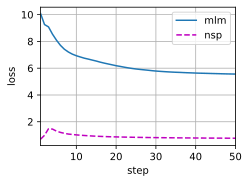

In [ ]:
train_bert(train_iter, net, loss, len(vocab), devices, 50)

# Represent text with BERT
https://d2l.ai/chapter_natural-language-processing-pretraining/bert-pretraining.html#representing-text-with-bert

In [ ]:
def get_bert_encoding(net, tokens_a, tokens_b=None):
  tokens, segments = d2l.get_tokens_and_segments(tokens_a, tokens_b)
  token_ids = torch.tensor(vocab[tokens], device=devices[0]).unsqueeze(0)
  segments = torch.tensor(segments, device=devices[0]).unsqueeze(0)
  valid_len = torch.tensor(len(tokens), device=devices[0]).unsqueeze(0)
  encoded_X, _, _ = net(token_ids, segments, valid_len)
  return encoded_X

tokens_a = ['a', 'crane', 'is', 'flying']
encoded_text = get_bert_encoding(net, tokens_a)
# Tokens: '<cls>', 'a', 'crane', 'is', 'flying', '<sep>'
encoded_text_cls = encoded_text[:, 0, :]
encoded_text_crane = encoded_text[:, 2, :]
print('encoded text shape = ', encoded_text.shape)
print('encoded text cls shape = ', encoded_text_cls.shape)
print('encoded text crane ', encoded_text_crane[0][:3])

print('#####')
print('with token b')
print('#####')

tokens_a, tokens_b = ['a', 'crane', 'driver', 'came'], ['he', 'just', 'left']
encoded_pair = get_bert_encoding(net, tokens_a, tokens_b)
# Tokens: '<cls>', 'a', 'crane', 'driver', 'came', '<sep>', 'he', 'just', 'left', '<sep>'
encoded_pair_cls = encoded_pair[:, 0, :]
encoded_pair_crane = encoded_pair[:, 2, :]
print('encoded pair shape = ', encoded_pair.shape)
print('encoded pair cls shape = ', encoded_pair_cls.shape)
print('encoded pair crane ', encoded_pair_crane[0][:3])

encoded text shape =  torch.Size([1, 6, 128])
encoded text cls shape =  torch.Size([1, 128])
encoded text crane  tensor([-0.6767, -0.9070, -2.5574], device='cuda:0', grad_fn=<SliceBackward0>)
#####
with token b
#####
encoded pair shape =  torch.Size([1, 10, 128])
encoded pair cls shape =  torch.Size([1, 128])
encoded pair crane  tensor([-0.3055, -0.2552, -0.2958], device='cuda:0', grad_fn=<SliceBackward0>)
